In [1]:
import os
import numpy as np
import braindynamics_starprotocol as bd
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
with open("./PATHS.json", "r") as f:
    paths_dict = json.load(f)

INPUT_DIR = paths_dict["input_dir"]
OUTPUT_DIR = paths_dict["output_dir"]

### Separating control & patient trials from trialinfo table

Information about the trials (what condition, which subject, ..) can be stored in a .csv file

In [3]:
info = pd.read_csv(os.path.join(INPUT_DIR, "Pipe02_trial_info.csv"))
control_trial_idx = info[info["condition"] == "Control"].index.values
patient_trial_idx = info[info["condition"] == "EtOH"].index.values

### Loading trial samples & separating into two groups

In [4]:
data = bd.TrialBrainData()
data.load_from_files(os.path.join(INPUT_DIR, "Pipe02_info.json"), os.path.join(INPUT_DIR, "Pipe02_samples.bin"))

control_trial_samps = [data.samp_mat_list[c] for c in control_trial_idx]
patient_trial_samps = [data.samp_mat_list[p] for p in patient_trial_idx]

### Preparing correlogram for SCA analysis

In [5]:
# PREPARING CORRELOGRAM FOR SCA
SCA_SCALE_SIZE = int(20*data.samp_freq) # scale size parameter for SCA
SCA_SHIFT_SIZE = int(20*data.samp_freq) # max shift size parameter for SCA
corrgram = bd.CrossCorrelogram(SCA_SHIFT_SIZE, scale_size=SCA_SCALE_SIZE)

### Extracting functional brain networks

In [6]:
## controls
control_networks = bd.NetworkData()
control_networks.extract(control_trial_samps, corrgram, export_to_filelists=(os.path.join(OUTPUT_DIR, "control_networks", "control_networks.filelist"), os.path.join(OUTPUT_DIR, "control_lags", "control_lags.filelist")))
control_networks.info_dict["node_label_list"] = data.info_dict["chan_name_list"]
# control_networks.load_from_filelist("control_networks/control_networks.filelist")

## patients
patient_networks = bd.NetworkData()
patient_networks.extract(patient_trial_samps, corrgram, export_to_filelists=(os.path.join(OUTPUT_DIR, "patient_networks", "patient_networks.filelist"), os.path.join(OUTPUT_DIR, "patient_lags", "patient_lags.filelist")))
patient_networks.info_dict["node_label_list"] = data.info_dict["chan_name_list"]
# patient_networks.load_from_filelist("patient_networks/patient_networks.filelist")

### Computing distributions

Determine max absolute weight, minimum and maximum node distance from both groups & use these values later

**Edge weight distribution (EWD)**

In [7]:
control_ewd = control_networks.compute_ewd()
patient_ewd = patient_networks.compute_ewd()

np.savetxt(os.path.join(OUTPUT_DIR, "control_networks-EWD.txt"), control_ewd, fmt="%.8f")
np.savetxt(os.path.join(OUTPUT_DIR, "patient_networks-EWD.txt"), patient_ewd, fmt="%.8f")

**Node distance distribution (NDD)**

Here we normalize edge weights if the maximum absolute value exceeds 1.0 (this can happen due to the interpolation in SCA, or numerical errors), so when calculating distances using $-\log (|w_{ij}|)$ we won't have negative distances.

In [8]:
# determine max absolute edge weights for both groups
max_weight = max(control_networks.get_maxabs_weights(), patient_networks.get_maxabs_weights())

# determine min and max node distance (shortest path length) for both groups
control_min_distance, control_max_distance = control_networks.get_minmax_distances(norm_factor=max_weight)
patient_min_distance, patient_max_distance = patient_networks.get_minmax_distances(norm_factor=max_weight)
min_distance = min(control_min_distance, patient_min_distance)
max_distance = max(control_max_distance, patient_max_distance)

In [9]:
control_ndd = control_networks.compute_ndd(bin_nr=15, ndd_vmin=min_distance, ndd_vmax=max_distance, norm_factor=max_weight)
patient_ndd = patient_networks.compute_ndd(bin_nr=15, ndd_vmin=min_distance, ndd_vmax=max_distance, norm_factor=max_weight)

np.savetxt(os.path.join(OUTPUT_DIR, "control_networks-NDD.txt"), control_ndd, fmt="%.8f")
np.savetxt(os.path.join(OUTPUT_DIR, "patient_networks-NDD.txt"), patient_ndd, fmt="%.8f")

**Node-edge weight distribution (N-EWD)**

This is an aggregated version of the regular EWD.

In [10]:
control_newd = control_networks.compute_newd()
patient_newd = patient_networks.compute_newd()

np.savetxt(os.path.join(OUTPUT_DIR, "control_networks-NEWD.txt"), control_newd, fmt="%.8f")
np.savetxt(os.path.join(OUTPUT_DIR, "patient_networks-NEWD.txt"), patient_newd, fmt="%.8f")

### Compute statistics

Cliff's deltas for NDD comparison

In [11]:
control_nds = control_networks.compute_nd_for_Cliffs_delta(norm_factor=max_weight)
patient_nds = patient_networks.compute_nd_for_Cliffs_delta(norm_factor=max_weight)
nds_Cliffs_deltas = bd.compare_nds_Cliffs_delta(patient_nds, control_nds)

np.savetxt(os.path.join(OUTPUT_DIR, "patient_control_networks-NDD-Cliffs_deltas.txt"), nds_Cliffs_deltas, fmt="%.8f")

Cliff's deltas for N-EWD 

NOTE: calculate for negative and positive part separately

In [12]:
control_news = control_networks.compute_new_for_Cliffs_delta()
patient_news = patient_networks.compute_new_for_Cliffs_delta()
news_Cliffs_deltas = bd.compare_news_Cliffs_delta(patient_news, control_news)

np.savetxt(os.path.join(OUTPUT_DIR, "patient_control_networks-NEWD-Cliffs_deltas.txt"), np.array(news_Cliffs_deltas).T, fmt="%.8f")

### Visualizing distributions

In [13]:
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 16

**Edge weight distribution (EWD)**

NOTE: For the edge weight distributions we use the last-to-first sorting of the rows (edges), this way the backbone (edges with strong positive correlations) will appear on the top.

In [14]:
_, ewd_sorting = bd.sort_distribution(control_ewd) # we want second sorting indices of rows, from last-to-first columns for EWD <=> backbone on top!
np.savetxt(os.path.join(OUTPUT_DIR, "control_networks-EWD-sorting_ltof.txt"), ewd_sorting, fmt="%d")

In [15]:
# determine NDD min/max value for both groups
ewd_cmin, ewd_cmax = min(np.min(control_ewd), np.min(patient_ewd)), max(np.max(control_ewd), np.max(patient_ewd))

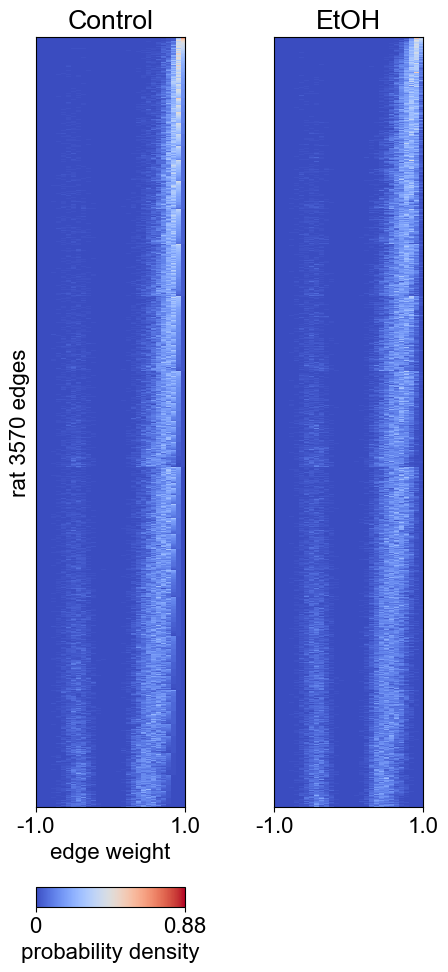

In [16]:
# create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 10), gridspec_kw={'width_ratios': [0.2, 0.2]})
plt.subplots_adjust(wspace=0.6)

bd.plot_distribution(control_ewd, sorting=ewd_sorting, fig=fig, ax=ax[0], cmin=ewd_cmin, cmax=ewd_cmax, show_cbar=True, clabel="probability density", title="Control", xlabel="edge weight", ylabel=f"rat {len(control_ewd)} edges", vmin=-1.0, vmax=1.0)
bd.plot_distribution(patient_ewd, sorting=ewd_sorting, fig=fig, ax=ax[1], cmin=ewd_cmin, cmax=ewd_cmax, clabel="probability density", title="EtOH", vmin=-1.0, vmax=1.0)
plt.savefig(os.path.join(OUTPUT_DIR, "patient_control_networks-EWD.png"), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(OUTPUT_DIR, "patient_control_networks-EWD.pdf"), bbox_inches='tight', dpi=300)

**Node distance distribution (NDD)**

NOTE: For the node distance distributions, we use the first-to-last sorting, this way the more central nodes will appear on the top.

In [17]:
ndd_sorting, _ = bd.sort_distribution(control_ndd) # sorting from first-to-last columns for NDD <=> more central nodes on the top!
np.savetxt(os.path.join(OUTPUT_DIR, "control_networks-NDD-sorting_ftol.txt"), ndd_sorting, fmt="%d")

In [18]:
# determine NDD min/max value for both groups
ndd_cmin, ndd_cmax = min(np.min(control_ndd), np.min(patient_ndd)), max(np.max(control_ndd), np.max(patient_ndd))

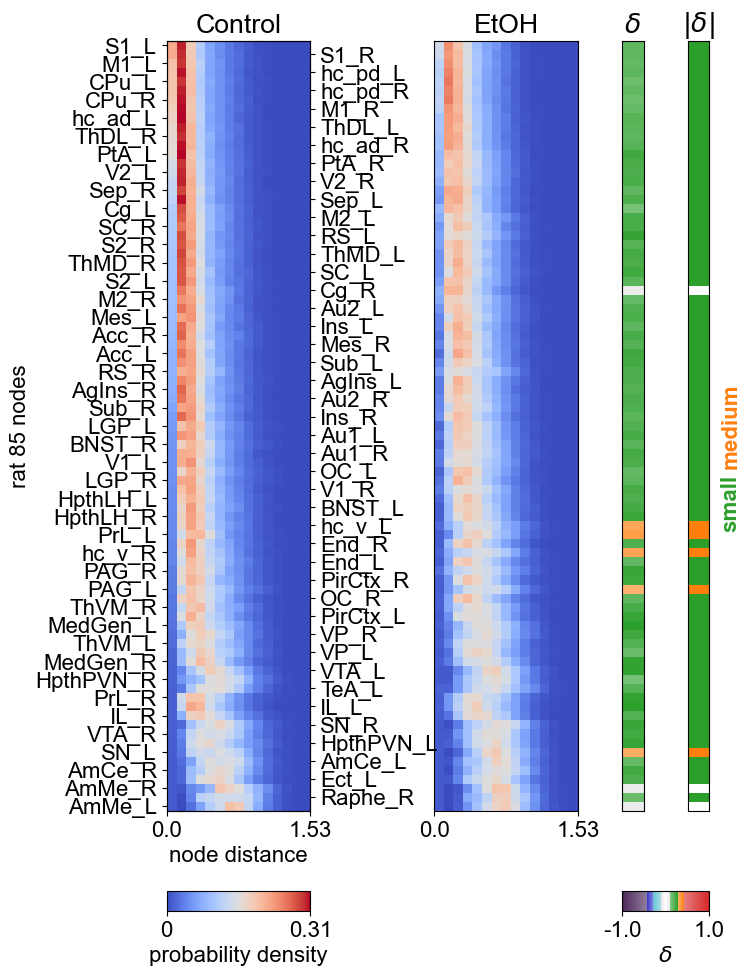

In [19]:

# create subplots
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(7, 10), gridspec_kw={'width_ratios': [0.2, 0.05, 0.2, 0.03, 0.03]})
plt.subplots_adjust(wspace=0.6)
ax[1].axis('off')

# plot NDD on separate axis for the two groups (but use the same sorting!!)
## controls
bd.plot_distribution(control_ndd, sorting=ndd_sorting, fig=fig, ax=ax[0], title="Control", xlabel="node distance", ylabel=f"rat {len(control_ndd)} nodes", show_cbar=True, cmin=ndd_cmin, cmax=ndd_cmax, clabel="probability density", vmin=min_distance, vmax=max_distance, yticks=control_networks.info_dict["node_label_list"], mirror_yticks=True)
## patients (with controls sorting!)
bd.plot_distribution(patient_ndd, sorting=ndd_sorting, fig=fig, ax=ax[2], title="EtOH",  cmin=ndd_cmin, cmax=ndd_cmax, vmin=min_distance, vmax=max_distance)
## Cliffs deltas
bd.plot_Cliffs_delta(np.expand_dims(nds_Cliffs_deltas, axis=1), sorting=ndd_sorting, fig=fig, axes=[ax[3], ax[4]], clabel=r'$\delta$', show_cbar=True, titles=[r'$\delta$', r'$|\delta|$'])

plt.savefig(os.path.join(OUTPUT_DIR, "control_patient_networks-NDD.png"), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(OUTPUT_DIR, "control_patient_networks-NDD.pdf"), bbox_inches='tight', dpi=300)

#### Plotting two distributions and their comparison on the same figure

**Node-edge weight distribution (N-EWD)**

Due to the bimodal nature of the node-edge weight distributions, when comparing them we calculate Cliff's $\delta$ metric separately for the negative and positive parts.

In [20]:
_, newd_sorting = bd.sort_distribution(control_newd) # sorting from first-to-last columns for NDD <=> more central nodes on the top!
np.savetxt(os.path.join(OUTPUT_DIR, "control_networks-NEWD-sorting_ltof.txt"), newd_sorting, fmt="%d")

In [21]:
# determine NEWD min/max value for both groups
newd_cmin, newd_cmax = min(np.min(control_newd), np.min(patient_newd)), max(np.max(control_newd), np.max(patient_newd))

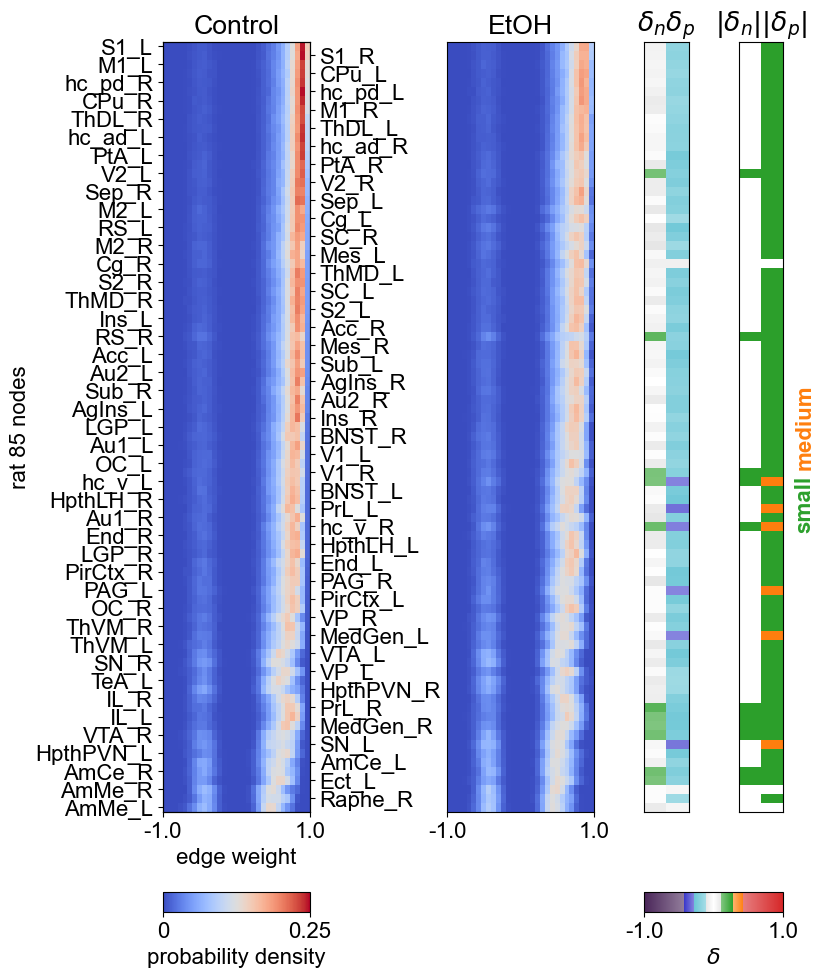

In [22]:
# create subplots
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(8, 10), gridspec_kw={'width_ratios': [0.2, 0.05, 0.2, 0.06, 0.06]})
plt.subplots_adjust(wspace=0.6)
ax[1].axis('off')

# plot N-EWDD on separate axis for the two groups (but use the same sorting!!)
## controls
bd.plot_distribution(control_newd, sorting=newd_sorting, fig=fig, ax=ax[0], title="Control", xlabel="edge weight", ylabel=f"rat {len(control_ndd)} nodes", show_cbar=True, cmin=newd_cmin, cmax=newd_cmax, clabel="probability density", yticks=control_networks.info_dict["node_label_list"], mirror_yticks=True, vmin=-1.0, vmax=1.0)
## patients (with controls sorting!)
bd.plot_distribution(patient_newd, sorting=newd_sorting, fig=fig, ax=ax[2], title="EtOH",  cmin=newd_cmin, cmax=newd_cmax, vmin=-1.0, vmax=1.0)
# plot Cliff's delta on another axes
bd.plot_Cliffs_delta(np.column_stack((news_Cliffs_deltas[0], news_Cliffs_deltas[1])), sorting=newd_sorting, fig=fig, axes=[ax[3], ax[4]], clabel=r'$\delta$', show_cbar=True, titles=[r'$\delta_n \delta_p$', r'$|\delta_n| |\delta_p|$'])

plt.savefig(os.path.join(OUTPUT_DIR, "control_patient_networks-NEWD.png"), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(OUTPUT_DIR, "control_patient_networks-NEWD.pdf"), bbox_inches='tight', dpi=300)